# Testing and merging the manual title subset

This is the notebook that created List # 4 in the report, the "manually-checked title subset."

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Load the data, confirm basic format

In [2]:
j = pd.read_csv('titledata/jessica.csv')
j.shape

(1200, 18)

In [3]:
p = pd.read_csv('titledata/patrick.csv')
p.shape

(1200, 18)

In [4]:
t = pd.read_csv('titledata/ted.tsv', sep = '\t')
t.shape

(330, 18)

In [5]:
set(p.columns) == set(j.columns)

True

In [6]:
set(p.columns) == set(t.columns)

True

## Confirm that values match our data dictionary

In [7]:
set(j.gender)

{'m', nan, 'u', 'o', 'f'}

In [8]:
set(p.gender)

{'m', nan, 'u', 'f'}

In [9]:
set(t.gender)

{nan, 'm', 'u', 'f'}

In practice, there is no difference between 'u' and nan; they both mean we don't know. The only difference between 'o' and 'u,' in this data, is that Jessica has used 'o' in five cases of multiple authorship; the other readers have not done the same thing, so we can't consistently maintain that distinction as part of the dictionary.

In [10]:
j.loc[j.gender == 'o', 'gender'] = 'u'

In [11]:
set(j.gender)

{'m', nan, 'u', 'f'}

In [12]:
j['gender'] = j['gender'].fillna(value = 'u')


In [13]:
p['gender'] = p['gender'].fillna(value = 'u')

In [14]:
t['gender'] = t['gender'].fillna(value = 'u')

There's one row where Jessica has double-listed nationality to address dual authorship. This is not something we've done consistently, so let's flatten it out to a single value.

In [15]:
j.loc[j.nationality == 'us| us', 'nationality'] = 'us'

**category**

According to our data dictionary in process.md https://github.com/tedunderwood/meta2018/blob/master/process.md the allowable codes here are

    nonfic
    reprint
    novel
    poetry
    shortstories
    juvenile

In subsequent conversation we added

    drama, and
    shortstories|juvenile
    juvenile|shortstories (order doesn't matter here)

In [16]:
set(p.category)

{'juvenile',
 'juvenile|novel',
 'juvenile|shortstories',
 'nonfic',
 'nonfic|juvenile',
 'nonfic|poetry',
 'novel',
 'novel|juvenile',
 'poetry',
 'reprint',
 'shortstories',
 'shortstories|juvenile',
 'shortstories|poetry'}

In [17]:
sum(pd.isnull(j.category))

0

In [18]:
t.loc[pd.isnull(t.category), 'author']

Series([], Name: author, dtype: object)

In [19]:
set(t.category)

{'drama', 'juvenile', 'nonfic', 'novel', 'poetry', 'reprint', 'shortstories'}

In [20]:
all = pd.concat([j, p, t])
all.head()

/Users/tunder/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


,allcopiesofwork,author,authordate,category,copiesin25yrs,docid,enumcron,firstpub,gender,genres,imprint,inferreddate,latestcomp,nationality,pseudonym,realname,shorttitle,subjects
0,1,"Fraser, Peter",1932-,nonfic,1,mdp.49015000838012,NaN,1971.0,m,Bibliographies|NotFiction,Boston|Plays inc.|1971,1971,1971,us,NaN,NaN,Puppet circus,Puppet theater
1,5,"Ferrier, Susan",1782-1854.,novel,3,mdp.39015063561586,v.2,1818.0,f,Bibliographies|Fiction,Edinburgh;W. Blackwood an,1818,1818,uk,NaN,"Ferrier, Susan Edmonstone","Marriage, a novel",English fiction
2,1,"Neri, Mary Anne",NaN,novel,1,uiuo.ark+=13960=t8nc6b618,v.1,1804.0,f,Novel|Fiction,London;Printed for T. Cad,1804,1804,it,NaN,"Neri, Mary Anne",The eve of San-Pietro,NaN
3,1,"Mann, Erika",1905-1969.,novel,1,uc1.$b473613,NaN,NaN,f,NotFiction,New York|Toronto|Farrar &,1940,1940,de,NaN,"Mann, Erika",The lights go down,Social life and customs
4,2,"Forrester, Charles Robert",1803-1850.,juvenile,2,nyp.33433074931597,v. 2,NaN,m,NotFiction,London;R. Bentley;1843.,1843,1843,uk,"Crowquill, Alfred; Willis, Hal","Forrester, Charles Robert",Phantasmagoria of fun,NaN


In [21]:
def isfiction(astring):
    if pd.isnull(astring):
        return 'non'
    
    if 'novel' in astring or 'shortstories' in astring:
        if 'juvenile' in astring:
            return 'juv'
        else:
            return 'fic'
    elif 'juvenile' in astring:
        return 'juv'
    else:
        return 'non'

all = all.assign(isfic = all.category.map(isfiction))

In [28]:
def lowestof(row):
    if pd.isnull(row['firstpub']):
        return int(row['latestcomp'])
    else:
        latest = int(row['latestcomp'])
        first = int(row['firstpub'])
        lowest = min(latest, first)
        if lowest > 1790:
            return lowest
        else:
            return latest

all = all.assign(firstpub = all.apply(lowestof, axis = 1))

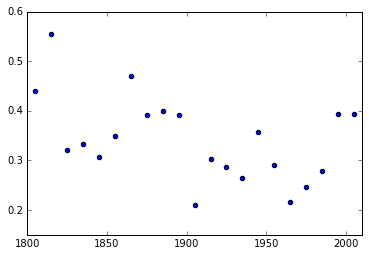

[41, 56, 25, 34, 24, 31, 49, 38, 36, 42, 20, 29, 28, 29, 35, 28, 22, 22, 31, 37, 43]


In [35]:
timeaxis = []
percentages = []
raw = []
for decade in range(1800, 2010, 10):
    in_decade = all.loc[(all.firstpub >= decade) & (all.firstpub < (decade + 10)) & ((all.isfic == 'fic')), : ]
    all_genders = sum(in_decade.gender == 'm') + sum(in_decade.gender == 'f')
    feminine = sum(in_decade.gender == 'f')
    pct = feminine / all_genders
    timeaxis.append(decade + 5)
    percentages.append(pct)
    raw.append(feminine)

plt.scatter(timeaxis, percentages)
plt.xlim(1800,2010)
plt.ylim(0.15, 0.6)
plt.show() 
print(raw)